Preprocessing video...
Displaying frames...


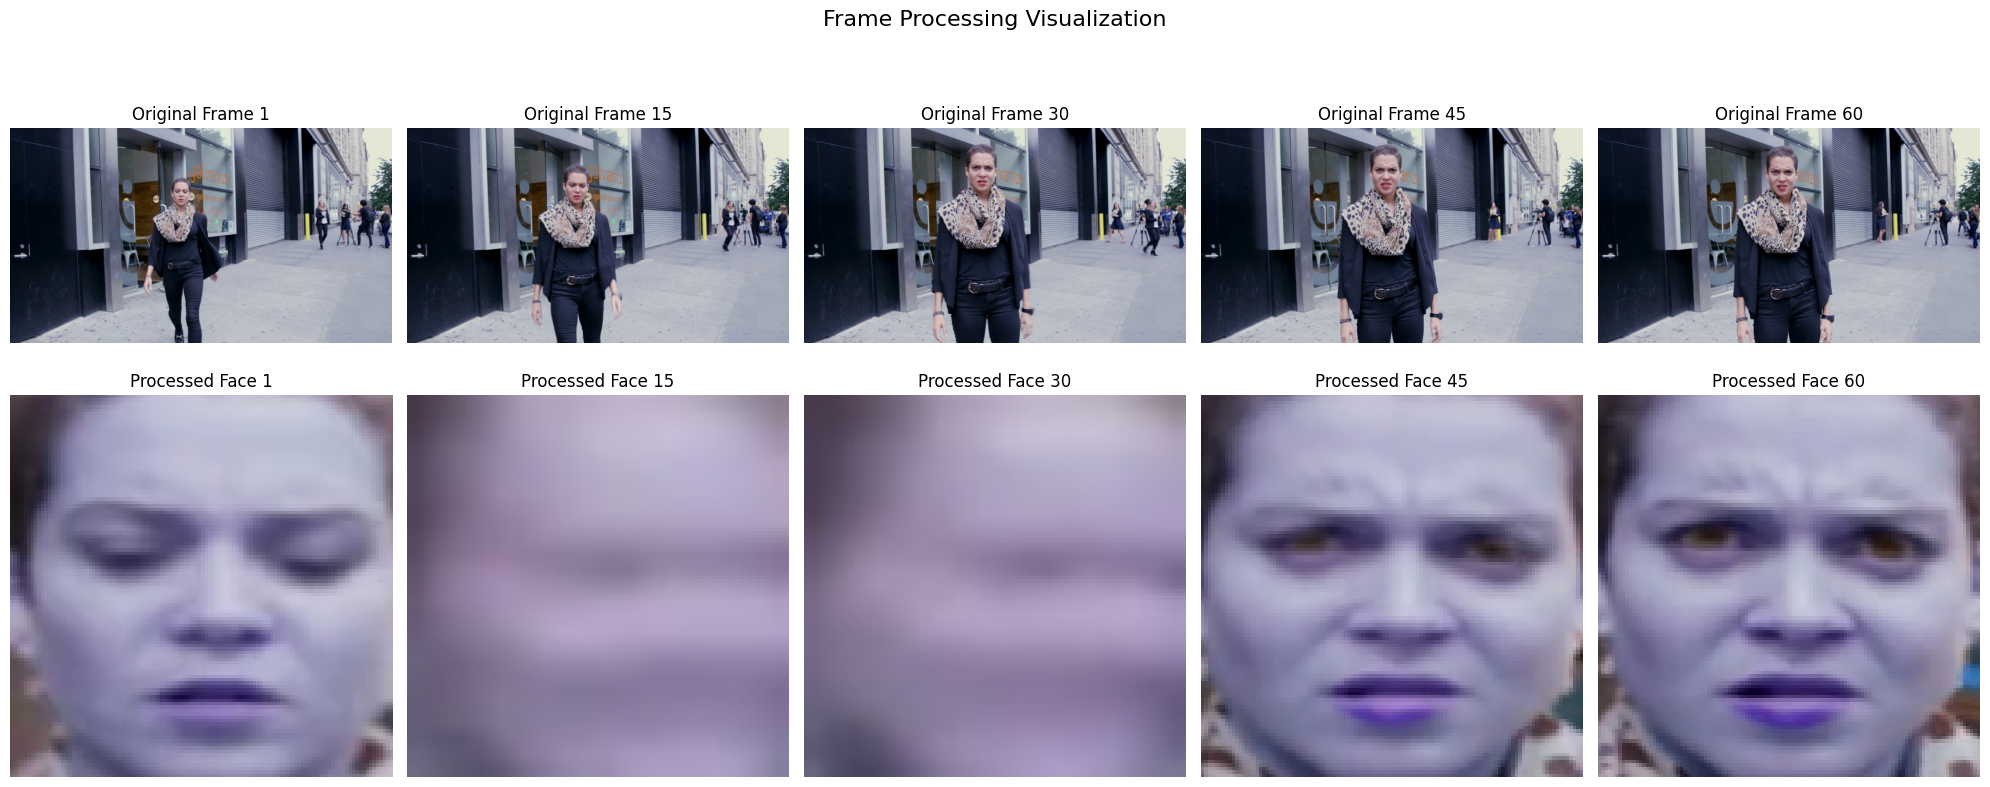

Making prediction...

Prediction Results:
Classification: Fake
Confidence: 75.88%
Probability Distribution:
- Fake: 75.88%
- Real: 24.12%


In [ ]:
import os
import torch
import cv2
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1
from torchvision import transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt

# DeepFakeDetector class remains the same
class DeepFakeDetector(nn.Module):
    def __init__(self, num_classes=2):
        super(DeepFakeDetector, self).__init__()
        self.facenet = InceptionResnetV1(pretrained='vggface2')
        for param in self.facenet.parameters():
            param.requires_grad = False
            
        self.lstm = nn.LSTM(512, 256, 2, batch_first=True)
        self.fc = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        embeddings = self.facenet(x)
        embeddings = embeddings.view(batch_size, seq_length, -1)
        lstm_out, _ = self.lstm(embeddings)
        lstm_out = torch.mean(lstm_out, dim=1)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        return out

class SingleVideoDataset(Dataset):
    def __init__(self, processed_video_path, sequence_length=10, transform=None):
        self.video_path = processed_video_path
        self.transform = transform
        self.sequence_length = sequence_length
        
    def __len__(self):
        return 1
    
    def __getitem__(self, idx):
        frames = []
        cap = cv2.VideoCapture(self.video_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        step = max(frame_count // self.sequence_length, 1)
        frame_indices = list(range(0, frame_count, step))[:self.sequence_length]
        
        for frame_idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                if self.transform:
                    frame = self.transform(frame)
                frames.append(frame)
        
        cap.release()
        
        while len(frames) < self.sequence_length:
            frames.append(frames[-1])
            
        return torch.stack(frames)

def display_frames(original_frames, processed_faces, num_frames=10):
    """Display original frames and their processed face counterparts"""
    n_frames = min(num_frames, len(original_frames))
    fig, axes = plt.subplots(2, n_frames, figsize=(20, 8))
    
    # Select evenly spaced frames
    frame_indices = np.linspace(0, len(original_frames)-1, n_frames, dtype=int)
    
    for i, idx in enumerate(frame_indices):
        # Display original frame
        axes[0, i].imshow(cv2.cvtColor(original_frames[idx], cv2.COLOR_BGR2RGB))
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Original Frame {idx+1}')
        
        # Display processed face
        if idx < len(processed_faces):
            axes[1, i].imshow(cv2.cvtColor(processed_faces[idx], cv2.COLOR_BGR2RGB))
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Processed Face {idx+1}')
    
    plt.suptitle('Frame Processing Visualization', fontsize=16)
    plt.tight_layout()
    plt.show()

def preprocess_video(input_video_path, output_path):
    """Preprocess a single video for prediction and return frames for visualization"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    mtcnn = MTCNN(keep_all=True, device=device)
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'MJPG'), 30, (112, 112))
    
    original_frames = []
    processed_faces = []
    
    cap = cv2.VideoCapture(input_video_path)
    frame_count = 0
    
    while cap.isOpened() and frame_count < 150:
        ret, frame = cap.read()
        if not ret:
            break
            
        original_frames.append(frame)  # Store original frame
        
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_pil = Image.fromarray(frame_rgb)
        
        boxes, _ = mtcnn.detect(frame_pil)
        if boxes is not None:
            for box in boxes:
                x1, y1, x2, y2 = map(int, box)
                try:
                    cropped_face = frame_rgb[y1:y2, x1:x2]
                    resized_face = cv2.resize(cropped_face, (112, 112))
                    processed_faces.append(resized_face)  # Store processed face
                    out.write(cv2.cvtColor(resized_face, cv2.COLOR_RGB2BGR))
                    frame_count += 1
                except Exception as e:
                    print(f"Error processing face: {e}")
                    
    cap.release()
    out.release()
    return output_path, original_frames, processed_faces

def predict_video(model_path, video_path):
    """Make prediction on a single video"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = DeepFakeDetector()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    model.to(device)
    
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((160, 160)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    dataset = SingleVideoDataset(video_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            outputs = model(batch)
            probabilities = torch.softmax(outputs, dim=1)
            
            pred_prob, prediction = torch.max(probabilities, dim=1)
            
            return {
                'prediction': 'Real' if prediction.item() == 1 else 'Fake',
                'confidence': pred_prob.item(),
                'fake_probability': probabilities[0][0].item(),
                'real_probability': probabilities[0][1].item()
            }

def main(input_video_path, model_path, temp_dir="temp_processed"):
    """Main function to process video, display frames, and make prediction"""
    try:
        os.makedirs(temp_dir, exist_ok=True)
        processed_video_path = os.path.join(
            temp_dir, 
            f"processed_{os.path.basename(input_video_path)}"
        )
        
        print("Preprocessing video...")
        processed_path, original_frames, processed_faces = preprocess_video(
            input_video_path, 
            processed_video_path
        )
        
        # Display frames
        print("Displaying frames...")
        display_frames(original_frames, processed_faces)
        
        print("Making prediction...")
        result = predict_video(model_path, processed_path)
        
        print("\nPrediction Results:")
        print(f"Classification: {result['prediction']}")
        print(f"Confidence: {result['confidence']:.2%}")
        print(f"Probability Distribution:")
        print(f"- Fake: {result['fake_probability']:.2%}")
        print(f"- Real: {result['real_probability']:.2%}")
        
        return result
        
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None
    finally:
        if os.path.exists(processed_video_path):
            os.remove(processed_video_path)

if __name__ == "__main__":
    MODEL_PATH = "video_detector.pth"  # Path to your trained model
    VIDEO_PATH = "C:/Users/Aditha Ayomal/Downloads/Video/01__kitchen_pan.mp4"  # Path to video you want to test
    #VIDEO_PATH = "C:/Users/User/Downloads/Test_DFD/real/02__podium_speech_happy.mp4"  # Path to video you want to test
    
    main(VIDEO_PATH, MODEL_PATH)